In [14]:
import matplotlib.pyplot as plt

In [19]:
import numpy as np

In [23]:
import cv2


img = cv2.imread("annotations/annotations/trimaps/._Abyssinian_1.png")

In [33]:
cv2.imread("annotations/annotations/trimap/Abyssinian_201.png")

[ WARN:0@814.676] global loadsave.cpp:248 findDecoder imread_('annotations/annotations/trimap/Abyssinian_201.png'): can't open/read file: check file path/integrity


In [37]:
image_path = "images/images/Abyssinian_100.jpg"
mask_path = "annotations/annotations/trimaps/Abyssinian_100.png"

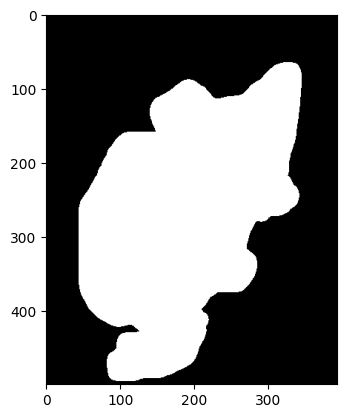

In [75]:
mask = cv2.imread(mask_path, 0)

# mask[mask==1] = 0
mask[mask==2] = 0
mask[mask>0] = 255

plt.imshow(mask, cmap='gray')

In [71]:
image = cv2.imread(image_path, 0)

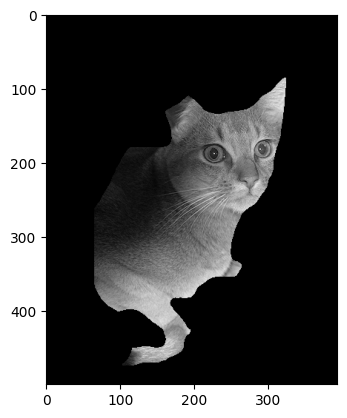

In [83]:
mask = cv2.imread(mask_path, 0)
image = cv2.imread(image_path, 0)

image[mask!=1] = 0
plt.imshow(image, cmap='gray')

In [93]:
import os
from typing import Iterable, Tuple

def get_image_and_mask(list_file: str) -> Iterable[Tuple[str, str]]:
    with open(list_file, "r") as f:
        # skip first 6 row
        for _ in range(6):
            next(f)
        for line in f:
            image_name = line.split(" ")[0]
            image_path = os.path.join(".", "images", "images", f"{image_name}.jpg")
            image_mask = os.path.join(".", "annotations", "annotations", "trimap", f"{image_name}.png")
            yield image_path, image_mask



In [92]:
image_mask

'./annotations/annotations/trimap/yorkshire_terrier_9.png'